In [1]:
import csv
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, recall_score
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import datetime
from random import randint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/rashi/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['randint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Reading Data file
df_demog = pd.read_csv('data/DataTables/tblGEnrollment.csv', sep=',', header=None)
# data table actually exists a directory above the views.py file
df_demog.columns = df_demog.iloc[0]
# Use first row info as header
df_demog.drop(df_demog.index[0], inplace=True)
# Drop first row

df_demog['Weight'] = pd.to_numeric(df_demog['Weight'])
df_demog['Height'] = pd.to_numeric(df_demog['Height'])

df_demog = df_demog.replace({'M':0,'F':1})

df_demog = df_demog[['PtID','Gender','Weight','Height']]
df_demog.rename(index=str, columns={"VisitDt":"ReadingDt"}, inplace=True)
# renaming date column name for consistency
df_demog.tail()

,PtID,Gender,Weight,Height
52,53,0,61.9,178.2
53,54,0,70.7,191.2
54,55,0,46.7,151.2
55,56,1,66.2,164.0
56,57,1,71.0,165.0


In [3]:
# Reading saved csv file
df_cgms = pd.read_csv('data/DataTables/modified_cgms.csv', sep=',', header=None)
# data table actually exists a directory above the views.py file
df_cgms.columns = df_cgms.iloc[0]
# Use first row info as header
df_cgms.drop(df_cgms.index[0], inplace=True)
# Drop first row
df_cgms.drop(df_cgms.columns[[0]], axis=1, inplace=True)
# removing the first column of NaNs that shows up from reading csv. Don't ask why. Sigh.
df_cgms.drop(['MeterBG', 'Diff'], axis=1, inplace=True)
# dropping these to get rid of unnecessary NaNs

df_cgms['SensorGLU'] = pd.to_numeric(df_cgms['SensorGLU'])
df_cgms['ExBG'] = pd.to_numeric(df_cgms['ExBG'])
df_cgms['Episode'] = pd.to_numeric(df_cgms['Episode'])
df_cgms['ExStat'] = pd.to_numeric(df_cgms['ExStat'])
df_cgms['BeforeEx'] = pd.to_numeric(df_cgms['BeforeEx'])
df_cgms['AfterEx'] = pd.to_numeric(df_cgms['AfterEx'])


df_cgms['Diff'] = df_cgms['SensorGLU'] - df_cgms['ExBG']
df_cgms['Diff'] = df_cgms['Diff'].abs()

print(len(df_cgms[df_cgms['Episode'] == 1]))
print(len(df_cgms[df_cgms['ExStat'] == 1]))
df_cgms.tail()

86
515


,PtID,GVisitType,ReadingDt,ReadingTm,SensorGLU,ExBG,ExStat,BeforeEx,AfterEx,Episode,Diff
14955,52,Basal stopped,2000-01-18,18:15,117,NaN,0,0,0,0,NaN
14956,52,Basal stopped,2000-01-18,18:20,117,156.0,0,0,0,0,39.0
14957,52,Basal stopped,2000-01-18,18:25,119,NaN,0,0,0,0,NaN
14958,52,Basal stopped,2000-01-18,18:30,125,NaN,0,0,0,0,NaN
14959,52,Basal stopped,2000-01-18,18:35,134,191.0,0,0,0,0,57.0


In [4]:
df_count = df_cgms.groupby(['PtID', 'ReadingDt']).count()
df_sum = df_cgms.groupby(['PtID', 'ReadingDt']).sum()
df_mean = df_cgms.groupby(['PtID', 'ReadingDt']).mean()
df_std = df_cgms.groupby(['PtID', 'ReadingDt']).std()
df_rolling = pd.DataFrame(df_cgms.groupby(['PtID', 'ReadingDt'])['SensorGLU'].rolling(12).mean())
# Creating input SEnsorGLU data as moving average
df_roll_avg = df_rolling.groupby(['PtID', 'ReadingDt']).mean()
df_roll_std = df_rolling.groupby(['PtID', 'ReadingDt']).std()

df_grouped = df_rolling.groupby(['PtID', 'ReadingDt'])

In [5]:
from tsfresh.feature_extraction.feature_calculators import *

peaked = []
for name, group in df_grouped:
    vals = group['SensorGLU'].values
    peaks = number_cwt_peaks(vals,12)
    peaked.append([name[0], name[1], peaks])
#    print(name, peaks,group)
df_peaks = pd.DataFrame(peaked)
df_peaks.columns = ['PtID', 'ReadingDt', 'Peaks']

df_peaks.head()

/home/rashi/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/rashi/anaconda3/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/home/rashi/anaconda3/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)


,PtID,ReadingDt,Peaks
0,10,2000-03-06,2
1,10,2000-03-18,3
2,11,2000-03-27,2
3,11,2000-04-17,2
4,12,2000-05-26,6


In [6]:
df_new = df_sum.reset_index()
# reset_index() changes grouped dataset rows into independent ones

df_new['Episode'] = df_sum.reset_index()['Episode'].gt(0).astype(int)
df_new['ExStat'] = df_sum.reset_index()['ExStat'].gt(0).astype(int)
# replace everything greater than 0 with 1 to make it binary

df_new['MeanSensor'] = df_roll_avg.reset_index()['SensorGLU']
df_new['MeanManual'] = df_mean.reset_index()['ExBG']
df_new['StdSensor'] = df_roll_std.reset_index()['SensorGLU']
df_new['StdManual'] = df_std.reset_index()['ExBG']
df_new['MeanDiff'] = df_mean.reset_index()['Diff']
df_new['StdDiff'] = df_std.reset_index()['Diff']

df_new.head()

,PtID,ReadingDt,SensorGLU,ExBG,ExStat,BeforeEx,AfterEx,Episode,Diff,MeanSensor,MeanManual,StdSensor,StdManual,MeanDiff,StdDiff
0,10,2000-03-06,9596,2079.0,1,149,61,1,446.0,120.613971,122.294118,27.132170,57.088489,26.235294,36.070295
1,10,2000-03-18,19125,3865.0,1,194,128,0,339.0,209.990506,193.250000,41.374198,47.874699,16.950000,16.359369
2,11,2000-03-27,14504,2597.0,1,144,82,0,490.0,168.853286,129.850000,53.699215,53.657074,24.500000,20.505455
3,11,2000-04-17,18700,4604.0,1,198,70,0,678.0,191.018939,184.160000,62.007654,65.501069,27.120000,33.025647
4,12,2000-05-26,32610,9470.0,1,0,294,0,1218.0,155.777219,175.370370,41.217450,50.089842,22.555556,9.791538


In [7]:
# Printing out unique patients in datasets
patients_demog = np.sort(np.unique(df_demog['PtID'].astype(int)))
print(patients_demog, len(patients_demog))
patients_new = np.sort(np.unique(df_new['PtID'].astype(int)))
print(patients_new, len(patients_new))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 51
 52 53 54 55 56 57] 56
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 51 52
 53 54 55 56 57] 55


In [8]:
print(df_new.dtypes, '\n', df_demog.dtypes)

0
PtID           object
ReadingDt      object
SensorGLU       int64
ExBG          float64
ExStat          int64
BeforeEx        int64
AfterEx         int64
Episode         int64
Diff          float64
MeanSensor    float64
MeanManual    float64
StdSensor     float64
StdManual     float64
MeanDiff      float64
StdDiff       float64
dtype: object 
 0
PtID       object
Gender      int64
Weight    float64
Height    float64
dtype: object


In [9]:
df1 = pd.merge(df_demog, df_new, on='PtID')
df = pd.merge(df1, df_peaks, on=['PtID','ReadingDt'])

df = df.drop(['SensorGLU','ExBG','Diff'], axis=1)
# drop 'SensorGLU','ExBG','Diff' as df_new summed them!

#df = df.drop(['Gender','Height','Weight'], axis=1)
# removing demographic info for now, as it made it completely deterministic!!
df['ExDiff'] = (df['BeforeEx'] - df['AfterEx']).abs()
df['BMI'] = df['Weight']/(df['Height']/100)**2

df.tail()

,PtID,Gender,Weight,Height,ReadingDt,ExStat,BeforeEx,AfterEx,Episode,MeanSensor,MeanManual,StdSensor,StdManual,MeanDiff,StdDiff,Peaks,ExDiff,BMI
132,55,0,46.7,151.2,2000-02-21,1,189,205,0,169.838235,170.928571,13.692916,35.921847,23.571429,14.340445,1,16,20.427410
133,56,1,66.2,164.0,2000-03-04,1,144,62,1,93.324755,96.333333,22.031929,28.982753,22.388889,18.081967,2,82,24.613325
134,56,1,66.2,164.0,2000-03-11,1,149,128,1,100.971774,109.470588,9.434306,39.285999,27.647059,13.105062,4,21,24.613325
135,57,1,71.0,165.0,2000-06-11,1,137,69,1,169.176802,139.562500,62.133351,73.054289,22.125000,18.463929,2,68,26.078972
136,57,1,71.0,165.0,2000-07-15,1,141,105,0,156.125000,140.368421,31.253131,55.183744,33.368421,20.437467,3,36,26.078972


In [10]:
df.to_csv('data/DataTables/features.csv', sep=',')
# Save modified dataframe to csv file

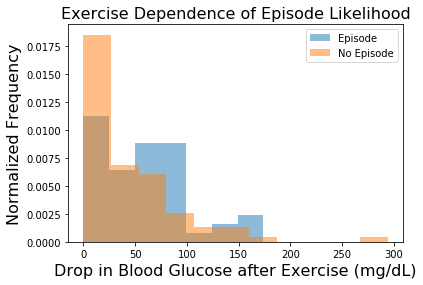

In [15]:
# Check trend of Exercise with episode
ex_id = df.columns.get_loc("ExDiff") 

hypo_yes = df[df['Episode'] == 1]
hypo_no = df[df['Episode'] == 0]

ex_yes = hypo_yes.iloc[:,ex_id].values
ex_no = hypo_no.iloc[:,ex_id].values
# exercise status

kwargs = dict(histtype='stepfilled', alpha=0.5, normed=True, bins='auto')

title('Exercise Dependence of Episode Likelihood', fontsize=16)
ylabel("Normalized Frequency", fontsize=16)
xlabel("Drop in Blood Glucose after Exercise (mg/dL)", fontsize=16)

plt.hist(ex_yes, **kwargs, label='Episode')
plt.hist(ex_no, **kwargs, label='No Episode')
plt.legend()

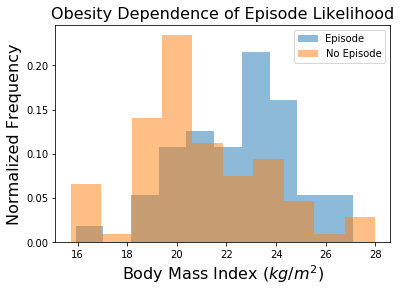

In [14]:
# Check trend of BMI with episode
bmi_id = df.columns.get_loc("BMI") 

hypo_yes = df[df['Episode'] == 1]
hypo_no = df[df['Episode'] == 0]

bmi_yes = hypo_yes.iloc[:,bmi_id].values
bmi_no = hypo_no.iloc[:,bmi_id].values
# BMI

kwargs = dict(histtype='stepfilled', alpha=0.5, normed=True, bins=10)

plt.hist(bmi_yes, **kwargs, label='Episode')
plt.hist(bmi_no, **kwargs, label='No Episode')

title('Obesity Dependence of Episode Likelihood', fontsize=16)
ylabel("Normalized Frequency", fontsize=16)
xlabel(r"Body Mass Index $(kg/m^2)$", fontsize=16)
plt.legend()